In [1]:
%load_ext watermark
# !pip install watermark -q
# !pip install msclap
# !pip install huggingface_hub[hf_xet] -q
print("-"*100)
%watermark -v
%watermark -p torch,torchvision,torchaudio -m
import torch, torchvision
print(f"CUDA version: {torch.version.cuda}")

----------------------------------------------------------------------------------------------------
Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.2.0



/home/IITB/ai-at-ieor/23m1521/.conda/envs/clap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch      : 2.1.2
torchvision: 0.16.2
torchaudio : 2.1.2

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 4.18.0-513.5.1.el8_9.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 48
Architecture: 64bit

CUDA version: 12.1


In [68]:
np.array(a.detach().cpu().tolist()).shape

(6, 3, 224, 224)

In [73]:
from torchvision.utils import make_grid

a = torch.rand(6, 3, 224, 224)
b = torch.rand(6, 3, 224, 224)
grid = make_grid(torch.cat([a, b], dim=0), nrow=6)
print(grid.shape)
grid

torch.Size([3, 454, 1358])


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.9547,  ..., 0.7285, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0052,  ..., 0.6931, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.3157,  ..., 0.7433, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.9874,  ..., 0.4706, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.8754,  ..., 0.8940, 0.0000, 0.

In [74]:
grid.numpy()

TypeError: expected 0 arguments, got 1

In [102]:
from typing import Any
from argparse import Namespace
import typing


class DotDict(Namespace):
    """A simple class that builds upon `argparse.Namespace`
    in order to make chained attributes possible."""

    def __init__(self, temp=False, key=None, parent=None) -> None:
        self._temp = temp
        self._key = key
        self._parent = parent

    def __eq__(self, other):
        if not isinstance(other, DotDict):
            return NotImplemented
        return vars(self) == vars(other)

    def __getattr__(self, __name: str) -> Any:
        if __name not in self.__dict__ and not self._temp:
            self.__dict__[__name] = DotDict(temp=True, key=__name, parent=self)
        else:
            del self._parent.__dict__[self._key]
            raise AttributeError("No attribute '%s'" % __name)
        return self.__dict__[__name]

    def __repr__(self) -> str:
        item_keys = [k for k in self.__dict__ if not k.startswith("_")]

        if len(item_keys) == 0:
            return "DotDict()"
        elif len(item_keys) == 1:
            key = item_keys[0]
            val = self.__dict__[key]
            return "DotDict(%s=%s)" % (key, repr(val))
        else:
            return "DotDict(%s)" % ", ".join(
                "%s=%s" % (key, repr(val)) for key, val in self.__dict__.items()
            )

    @classmethod
    def from_dict(cls, original: typing.Mapping[str, any]) -> "DotDict":
        """Create a DotDict from a (possibly nested) dict `original`.
        Warning: this method should not be used on very deeply nested inputs,
        since it's recursively traversing the nested dictionary values.
        """
        dd = DotDict()
        for key, value in original.items():
            if isinstance(value, typing.Mapping):
                value = cls.from_dict(value)
            setattr(dd, key, value)
        return dd
    
from torchvision.transforms import v2
import pprint, os, pandas as pd
import torch
import torchvision as tv
import yaml
config_path = "/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/config-VQVAE.yaml"
with open(config_path, 'r') as file:
    Config = yaml.safe_load(file)
    pprint.pprint(Config, width=120)

Config = DotDict.from_dict(Config)
dataset_config = Config.dataset_params
diffusion_config = Config.diffusion_params
model_config = Config.model_params
train_config = Config.train_params
paths = Config.paths


# ==================================================================
#                   V A A N I - D A T A S E T
# ==================================================================
IMAGES_PATH = paths.images_dir

def walkDIR(folder_path, include=None):
    file_list = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if include is None or any(file.endswith(ext) for ext in include):
                file_list.append(os.path.join(root, file))
    print("Files found:", len(file_list))
    return file_list

files = walkDIR(IMAGES_PATH, include=['.png', '.jpeg', '.jpg'])
df = pd.DataFrame(files, columns=['image_path'])

class VaaniDataset(torch.utils.data.Dataset):
    def __init__(self, files_paths, im_size):
        self.files_paths = files_paths
        self.im_size = im_size

    def __len__(self):
        return len(self.files_paths)

    def __getitem__(self, idx):
        image = tv.io.read_image(self.files_paths[idx], mode=tv.io.ImageReadMode.RGB)
        # image = tv.io.decode_image(self.files_paths[idx], mode=tv.io.ImageReadMode.RGB)
        image = v2.Resize((self.im_size,self.im_size))(image)
        image = v2.ToDtype(torch.float32, scale=True)(image)
        # image = 2*image - 1
        return image

dataset = VaaniDataset(files_paths=files, im_size=dataset_config.im_size)
image = dataset[2]
print('IMAGE SHAPE:', image.shape)

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=train_config.autoencoder_batch_size, 
    shuffle=True, 
    num_workers=10,
    pin_memory=False,
    drop_last=True,
    persistent_workers=True
)

images = next(iter(dataloader))
print('BATCH SHAPE:', images.shape)

{'autoencoder_params': {'attn_down': [False, False],
                        'codebook_size': 20,
                        'down_channels': [32, 64, 128],
                        'down_sample': [True, True],
                        'mid_channels': [128, 128],
                        'norm_channels': 32,
                        'num_down_layers': 4,
                        'num_heads': 16,
                        'num_mid_layers': 4,
                        'num_up_layers': 4,
                        'z_channels': 3},
 'dataset_params': {'im_channels': 3, 'im_size': 128},
 'diffusion_params': {'beta_end': 0.0195, 'beta_start': 0.0015, 'num_timesteps': 1000},
 'ldm_params': {'attn_down': [True, True, True],
                'conv_out_channels': 128,
                'down_channels': [128, 256, 256, 256],
                'down_sample': [False, False, False],
                'mid_channels': [256, 256],
                'norm_channels': 32,
                'num_down_layers': 2,
                

/home/IITB/ai-at-ieor/23m1521/.conda/envs/clap/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


BATCH SHAPE: torch.Size([80, 3, 128, 128])


In [103]:
images.shape

torch.Size([80, 3, 128, 128])

In [107]:
images[-6:,:,:,:].shape

torch.Size([6, 3, 128, 128])

(260, 782, 3)


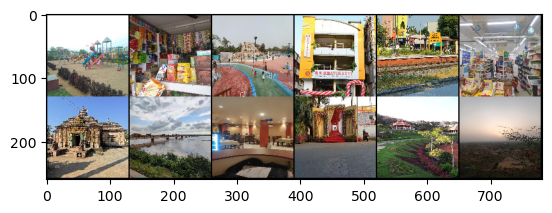

In [192]:
from torchvision.utils import make_grid
from PIL import Image, ImageShow

# a = torch.rand(6, 3, 224, 224)
# b = torch.rand(6, 3, 224, 224)
a = images[:6,:,:,:]
b = images[-6:,:,:,:]
grid = make_grid(torch.cat([a, b], dim=2), nrow=6, normalize=True, scale_each=True).permute(1,2,0).detach().cpu().numpy()
# grid = make_grid(torch.dstack([a, b]), nrow=6).permute(1,2,0).detach().cpu().numpy()
print(grid.shape)
plt.imshow(grid)
# img = Image.fromarray(grid, mode='RGB')
# img

In [151]:
# images[:25,:,:,:]

In [160]:
a = images[:4,:,:,:]

In [161]:
a.shape

torch.Size([4, 3, 128, 128])

In [171]:
a = images[:25,:,:,:]
int(a.shape[0]**.5)

5

torch.Size([6, 3, 128, 128])


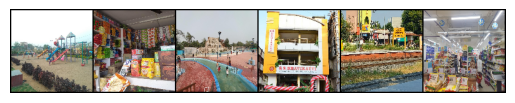

torch.Size([6, 3, 128, 128])


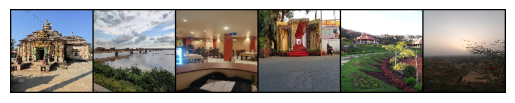

torch.Size([6, 3, 256, 128])


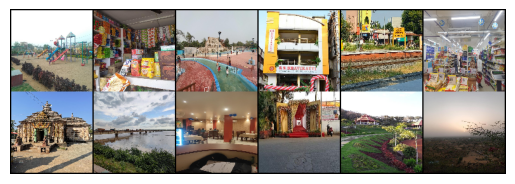

In [189]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

a = images[:6,:,:,:]
print(a.shape)
grid = vutils.make_grid(a, nrow=6, normalize=True, scale_each=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

b = images[-6:,:,:,:]
print(b.shape)
grid = vutils.make_grid(b, nrow=6, normalize=True, scale_each=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

batch = torch.cat((a, b), dim=2)
print(batch.shape)
grid = vutils.make_grid(batch, nrow=6, normalize=True, scale_each=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [16]:
import torch
empty_audio_embedding = torch.zeros(1024).float()
print(empty_audio_embedding.shape)
empty_audio_embedding.unsqueeze(0).repeat(4, 1).unsqueeze(1).shape

torch.Size([1024])


torch.Size([4, 1, 1024])

In [31]:
import glob
import os

# Adjust the path to the correct directory where files are located
vae_checkpoint_path = os.path.abspath(os.path.join(os.getcwd(), "VaaniLDM"))
print(vae_checkpoint_path)

# List contents to verify
print(os.listdir(vae_checkpoint_path))

# Correct pattern for files in the VaaniLDM directory
correct_pattern = os.path.join(vae_checkpoint_path, "vqvaq_ckpt_epoch*.pt")
print(correct_pattern)

# Use glob with the corrected pattern
matched_files = glob.glob(correct_pattern)
print(matched_files)


/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/VaaniLDM
['vqvae_recon', 'vqvaq_ckpt_epoch54.pt', 'vqvaq_ckpt_epoch55.pt']
/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/VaaniLDM/vqvaq_ckpt_epoch*.pt
['/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/VaaniLDM/vqvaq_ckpt_epoch54.pt', '/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/VaaniLDM/vqvaq_ckpt_epoch55.pt']


In [35]:
import glob
import os
vae_checkpoint_path = os.path.join(os.getcwd(), "VaaniLDM", "vqvaq_ckpt")
print(vae_checkpoint_path)

# print(os.listdir("/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/VaaniLDM/"))

print(f"{vae_checkpoint_path}_epoch*.pt")
correct_pattern = os.path.join(vae_checkpoint_path, "vqvaq_ckpt_epoch*.pt")
print(correct_pattern)

glob.glob(f"{vae_checkpoint_path}_epoch*.pt")

/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/VaaniLDM/vqvaq_ckpt
/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/VaaniLDM/vqvaq_ckpt_epoch*.pt
/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/VaaniLDM/vqvaq_ckpt/vqvaq_ckpt_epoch*.pt


['/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/VaaniLDM/vqvaq_ckpt_epoch54.pt',
 '/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/VaaniLDM/vqvaq_ckpt_epoch55.pt']

(262, 782, 3)


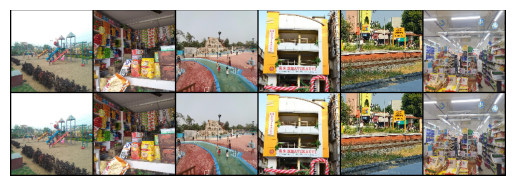

In [215]:
image_tensors = []
for i in range(6):
        image_tensors.append(images[i].unsqueeze(0))

a = torch.cat(image_tensors, dim=0)    
b = torch.cat(image_tensors, dim=0)
batch = torch.cat((a,b), dim=0)
grid = vutils.make_grid(batch, nrow=6, normalize=True, scale_each=True)
img = grid.permute(1, 2, 0).cpu().numpy()
print(img.shape)
# plt.imsave('output_image2.png', img)
plt.imshow(img)
plt.axis('off')
# plt.show()
np_img = (grid * 255).byte().numpy().transpose(1, 2, 0)
image = Image.fromarray(np_img)
image.save("output_image.png")

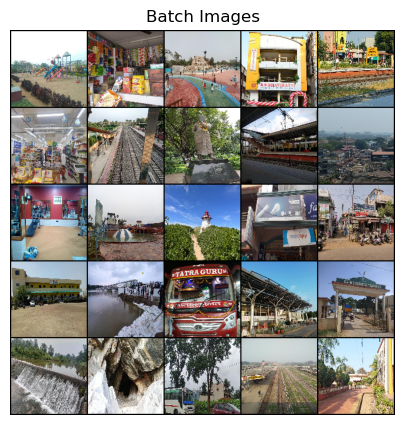

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
def plot_batch(batch, nrow=2, title='Batch Images'):
    # images = batch[0]
    grid = vutils.make_grid(batch, nrow=nrow, normalize=True, scale_each=True)
    plt.figure(figsize=(nrow, nrow))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

a = images[:25,:,:,:]
plot_batch(a, int(a.shape[0]**.5))

In [146]:
torch.stack((a, b), dim=0).shape

torch.Size([2, 6, 3, 128, 128])

In [133]:
torch.dstack([a, b]).shape

torch.Size([6, 3, 256, 128])

In [124]:
grid = np.array(grid.numpy())

In [121]:
grid = np.array(grid).astype(np.float64)
print(grid.shape)
Image.fromarray(grid, mode='RGB').save("output_image.png")

ValueError: object __array__ method not producing an array

In [112]:
grid

array([[[4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.],
        ...,
        [4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.]],

       [[4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.],
        ...,
        [4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.]],

       [[4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.],
        ...,
        [4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.]],

       ...,

       [[4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.],
        ...,
        [4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.]],

       [[4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.],
        ...,
        [4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.]],

       [[4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.],
        ...,
        [4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.]]])

In [2]:
import os
import pandas as pd

AUDIO_DIR = r"/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios"

Successfully installed librosa-0.10.2.post1 llvmlite-0.41.1 msclap-1.3.3 numba-0.58.1 numpy-1.26.4 nvidia-cublas-cu12-12.1.3.1 nvidia-cuda-cupti-cu12-12.1.105 nvidia-cuda-nvrtc-cu12-12.1.105 nvidia-cuda-runtime-cu12-12.1.105 nvidia-cudnn-cu12-8.9.2.26 nvidia-cufft-cu12-11.0.2.54 nvidia-curand-cu12-10.3.2.106 nvidia-cusolver-cu12-11.4.5.107 nvidia-cusparse-cu12-12.1.0.106 nvidia-nccl-cu12-2.18.1 nvidia-nvjitlink-cu12-12.4.127 nvidia-nvtx-cu12-12.1.105 torch-2.1.2 torchaudio-2.1.2 torchlibrosa-0.1.0 torchvision-0.16.2 triton-2.1.0

In [3]:
def insert_audio_language(paths, audio_language):
    updated_paths = []
    for path in paths:
        parts = path.split('/')
        # Find the index of 'Audios'
        if 'Audios' in parts:
            idx = parts.index('Audios')
            # Remove 'Audios' and insert audio_language in its place
            parts[idx] = audio_language
            updated_path = '/'.join(parts)
            updated_paths.append(updated_path)
        else:
            # If 'Audios' not found, keep the path unchanged
            updated_paths.append(path)
    return updated_paths


def apply_insert_audio_language(path, audio_language):
    result = insert_audio_language([path], audio_language)
    return result[0]

def walkDIR(folder_path, include=None):    
    file_list = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if include is None or any(file.endswith(ext) for ext in include):
                file_list.append(os.path.join(root, file))
    print("Files found:", len(file_list))
    return file_list

def combine_state_district(path, state):
    # Remove leading slash and split
    parts = path.lstrip('/').split('/')
    
    # Check if 'English' is in parts and there is a district after it
    if 'English' in parts and len(parts) > parts.index('English') + 1:
        idx = parts.index('English')
        district = parts[idx + 1]
        
        # Combine state and district
        combined = f"{state}_{district}"
        parts[idx + 1] = combined
        
        updated_path = '/'.join(parts)
        return updated_path
    else:
        # If conditions not met, keep path unchanged (but without leading slash)
        return path.lstrip('/')

In [4]:
import pandas as pd # type: ignore
AUDIO_CSV = r"/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/Vaani-Audio-Image-English.csv"

engMETA = pd.read_csv(AUDIO_CSV)
audio_language = "English"
engMETA.audioFileName = engMETA.audioFileName.apply(lambda x: apply_insert_audio_language(x, audio_language))
engMETA['audioFileName2'] = engMETA.apply(lambda row: combine_state_district(row['audioFileName'], row['state']), axis=1)
engMETA.drop(columns=['audioFileName'], inplace=True)
engMETA.insert(8, 'audioFileName', engMETA.pop('audioFileName2'))
engMETA

id                                          file_name  \
0      58213  IISc_VaaniProject_S_Chhattisgarh_Rajnandgaon_1...   
1      58214  IISc_VaaniProject_S_Chhattisgarh_Rajnandgaon_1...   
2      58215  IISc_VaaniProject_S_Chhattisgarh_Rajnandgaon_1...   
3      58216  IISc_VaaniProject_S_Chhattisgarh_Rajnandgaon_1...   
4      58217  IISc_VaaniProject_S_Chhattisgarh_Rajnandgaon_1...   
..       ...                                                ...   
920  9613351  IISc_VaaniProject_S_Telengana_Karimnagar_10592...   
921  9613352  IISc_VaaniProject_S_Telengana_Karimnagar_10592...   
922  9613353  IISc_VaaniProject_S_Telengana_Karimnagar_10592...   
923  9613354  IISc_VaaniProject_S_Telengana_Karimnagar_10592...   
924  9613355  IISc_VaaniProject_S_Telengana_Karimnagar_10592...   

                                              file_url assertLanguage  \
0    https://vaani.iisc.ac.in/Audios/Rajnandgaon/II...        English   
1    https://vaani.iisc.ac.in/Audios/Rajnandgaon/II...        English   
2    https://vaani.iisc.ac.in/Audios/Rajnandgaon/II...        English   
3    https://vaani.iisc.ac.in/Audios/Rajnandgaon/II...        English   
4    https://vaani.iisc.ac.in/Audios/Rajnandgaon/II...        English   
..                                                 ...            ...   
920  https://vaani.iisc.ac.in//Audios/Karimnagar/II...        English   
921  https://vaani.iisc.ac.in//Audios/Karimnagar/II...        English   
922  https://vaani.iisc.ac.in//Audios/Karimnagar/II...        English   
923  https://vaani.iisc.ac.in//Audios/Karimnagar/II...        English   
924  https://vaani.iisc.ac.in//Audios/Karimnagar/II...        English   

          languagesSpoken         state     district  gender  \
0     ['Hindi' 'English']  Chhattisgarh  Rajnandgaon  female   
1     ['Hindi' 'English']  Chhattisgarh  Rajnandgaon  female   
2     ['Hindi' 'English']  Chhattisgarh  Rajnandgaon  female   
3     ['Hindi' 'English']  Chhattisgarh  Rajnandgaon  female   
4     ['Hindi' 'English']  Chhattisgarh  Rajnandgaon  female   
..                    ...           ...          ...     ...   
920  ['Telugu' 'English']     Telangana   Karimnagar  female   
921  ['Telugu' 'English']     Telangana   Karimnagar  female   
922  ['Telugu' 'English']     Telangana   Karimnagar  female   
923  ['Telugu' 'English']     Telangana   Karimnagar  female   
924  ['Telugu' 'English']     Telangana   Karimnagar  female   

                                         audioFileName  \
0    English/Chhattisgarh_Rajnandgaon/IISc_VaaniPro...   
1    English/Chhattisgarh_Rajnandgaon/IISc_VaaniPro...   
2    English/Chhattisgarh_Rajnandgaon/IISc_VaaniPro...   
3    English/Chhattisgarh_Rajnandgaon/IISc_VaaniPro...   
4    English/Chhattisgarh_Rajnandgaon/IISc_VaaniPro...   
..                                                 ...   
920  English/Telangana_Karimnagar/IISc_VaaniProject...   
921  English/Telangana_Karimnagar/IISc_VaaniProject...   
922  English/Telangana_Karimnagar/IISc_VaaniProject...   
923  English/Telangana_Karimnagar/IISc_VaaniProject...   
924  English/Telangana_Karimnagar/IISc_VaaniProject...   

                                 imageFileName  pincode       speakerImageHash  
0    Images/IISc_VaaniProject_GENERIC_0602.jpg   491441  (krxx+nk 1<0~A3:Ai|q)  
1    Images/IISc_VaaniProject_GENERIC_0717.jpg   491441  (krxx0kr 1<0~A3:Ai}r.  
2    Images/IISc_VaaniProject_GENERIC_0635.jpg   491441  (kryq/io 1<0~A3:Ai|t,  
3    Images/IISc_VaaniProject_GENERIC_1036.jpg   491441  (krxv(pi 1<0~A3:Ajvt-  
4    Images/IISc_VaaniProject_GENERIC_0623.jpg   491441  (krys.rp 1<0~A3:Ai|s*  
..                                         ...      ...                    ...  
920  Images/IISc_VaaniProject_GENERIC_0317.jpg   505467  (jlwq.nn 1<0~A3:Aiyr.  
921  Images/IISc_VaaniProject_GENERIC_0042.jpg   505467  (jlwz(qo 1<0~A3:Aivu)  
922  Images/IISc_VaaniProject_GENERIC_0220.jpg   505467  (jlwv~qo 1<0~A3:Aixs~  
923  Images/IISc_VaaniProject_GENERIC_0309.jpg   505

In [5]:
audios_path = [os.path.join(AUDIO_DIR, i) for i in engMETA.audioFileName.to_list()]
audios_path[:3]

['/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/Chhattisgarh_Rajnandgaon/IISc_VaaniProject_S_Chhattisgarh_Rajnandgaon_138471_12927452_BHBSBC_124341_8_10983.wav',
 '/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/Chhattisgarh_Rajnandgaon/IISc_VaaniProject_S_Chhattisgarh_Rajnandgaon_138471_12927929_APATRI_67501_8_3569.wav',
 '/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/Chhattisgarh_Rajnandgaon/IISc_VaaniProject_S_Chhattisgarh_Rajnandgaon_138471_12930806_CGBTSH_28932_8740_12720.wav']

In [6]:
files = walkDIR(AUDIO_DIR, include=['.wav'])
files[:3]

Files found: 925


['/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/Karnataka_Bellary/IISc_VaaniProject_S_Karnataka_Bellary_74990_10124626_IMG20220914105526_35_12882.wav',
 '/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/Karnataka_Bellary/IISc_VaaniProject_S_Karnataka_Bellary_74990_10107436_BHVSFE_25230_140_12011.wav',
 '/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/Karnataka_Bellary/IISc_VaaniProject_S_Karnataka_Bellary_74990_10105645_KTBECLT_340740_10196_16473.wav']

In [7]:
print(sorted(audios_path)[:3])
print(sorted(files)[:3])

['/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/AndhraPradesh_Guntur/IISc_VaaniProject_S_AP_Guntur_66656_9672685_BHMQ_155525_0_9216.wav', '/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/AndhraPradesh_Guntur/IISc_VaaniProject_S_AP_Guntur_66656_9672685_BHMQ_155525_9257_16419.wav', '/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/AndhraPradesh_Guntur/IISc_VaaniProject_S_AP_Guntur_66656_9672947_BHPA_135260_16372_19511.wav']
['/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/AndhraPradesh_Guntur/IISc_VaaniProject_S_AP_Guntur_66656_9672685_BHMQ_155525_0_9216.wav', '/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/AndhraPradesh_Guntur/IISc_VaaniProject_S_AP_Guntur_66656_9672685_BHMQ_155525_9257_16419.wav', '/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/AndhraPradesh_Guntur/IISc_VaaniProject_S_AP_Guntur_66656_9672947_BHPA_135260_16372_19511.wav']


In [8]:
for i in audios_path:
    if not os.path.isfile(i):
        print(i)

In [11]:
from msclap import CLAP

clap_model = CLAP(version = '2023', use_cuda=True)
audio_embeddings = {'audioFileName':[], 'audio_embedding':[]}

for path in audios_path:
    audio_embeddings['audioFileName'].append(path)
    audio_embeddings['audioFileName'].append(
        clap_model.get_audio_embeddings([path]).cpu().numpy()
        # clap_model.get_audio_embeddings([path])
    )
    
audio_embeddings

{'audioFileName': ['/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/Chhattisgarh_Rajnandgaon/IISc_VaaniProject_S_Chhattisgarh_Rajnandgaon_138471_12927452_BHBSBC_124341_8_10983.wav',
  array([[ 0.21912347, -0.07575455,  1.0714684 , ..., -0.03732714,
           0.05369334, -0.09379762]], dtype=float32),
  '/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/Chhattisgarh_Rajnandgaon/IISc_VaaniProject_S_Chhattisgarh_Rajnandgaon_138471_12927929_APATRI_67501_8_3569.wav',
  array([[-0.8901101 , -1.6882378 ,  0.5023358 , ...,  0.09641699,
           0.78282595,  0.6133272 ]], dtype=float32),
  '/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/Chhattisgarh_Rajnandgaon/IISc_VaaniProject_S_Chhattisgarh_Rajnandgaon_138471_12930806_CGBTSH_28932_8740_12720.wav',
  array([[-0.874512  , -1.5307312 ,  1.2123786 , ...,  0.41698596,
           0.8809516 ,  0.85869825]], dtype=float32),
  '/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani/Audios/English/Chhattisgarh_R

In [12]:
from msclap import CLAP

# Load model (Choose between versions '2022' or '2023')
# The model weight will be downloaded automatically if `model_fp` is not specified
clap_model = CLAP(version = '2023', use_cuda=True)

# Extract audio embeddings
audio_embeddings = clap_model.get_audio_embeddings(audios_path)
audio_embeddings.shape

torch.Size([925, 1024])